In [8]:
import os
import numpy as np
import torchvision.datasets as datasets
import torch
from torch.optim import Adam
from torchvision import models
import torchvision.transforms as transforms
from misc_functions import preprocess_image, recreate_image, save_image
import matplotlib.pyplot as plt
import matplotlib

In [2]:
class Data():
    
    def __init__(self):
        
        self.train_set = datasets.CIFAR10(
        root = './data',
        train = True,
        download = True,
        transform = transforms.Compose([transforms.Resize(224), transforms.ToTensor()])
        )

        self.test_set = datasets.CIFAR10(
        root= './data',
        train= False,
        download = True,
        transform = transforms.Compose([transforms.Resize(224), transforms.ToTensor()])
        )
        
    def get_data(self):
        return [self.train_set, self.test_set]

In [16]:
data = Data()
train, test = data.get_data()
train_loader = torch.utils.data.DataLoader(train, batch_size= 10, shuffle= True)
test_loader = torch.utils.data.DataLoader(test, batch_size= 10000, shuffle= True)

Files already downloaded and verified
Files already downloaded and verified


In [17]:
images, labels = next(iter(train_loader))
labels, images.shape

(tensor([2, 0, 6, 0, 4, 4, 7, 8, 1, 0]), torch.Size([10, 3, 224, 224]))

In [71]:
class CNNLayerVisualization():
    """
        Produces an image that minimizes the loss of a convolution
        operation for a specific layer and filter
    """
    def __init__(self, model, selected_layer, selected_filter):
        self.model = model
        self.model.eval()
        self.selected_layer = selected_layer
        self.selected_filter = selected_filter
        self.conv_output = 0
        # Create the folder to export images if not exists
        if not os.path.exists('generated'):
            os.makedirs('generated')

    def hook_layer(self):
        def hook_function(module, grad_in, grad_out):
            # Gets the conv output of the selected filter (from selected layer)
            print(grad_out[0, self.selected_filter].shape)
            self.conv_output = grad_out[0, self.selected_filter]
        # Hook the selected layer
        self.model[self.selected_layer].register_forward_hook(hook_function)

    def visualise_layer_with_hooks(self):
        # Hook the selected layer
        self.hook_layer()
        # Generate a random image
        #random_image = np.uint8(np.random.uniform(150, 180, (224, 224, 3)))
        random_image = images[3].permute(2,1,0)
        # Process image and return variable
        print("random image ", random_image.shape)
        processed_image = preprocess_image(random_image, False)
        print("processed images size", processed_image.shape)
        # Define optimizer for the image
        optimizer = Adam([processed_image], lr=0.1, weight_decay=1e-6)
        for i in range(1, 145):
            optimizer.zero_grad()
            # Assign create image to a variable to move forward in the model
            x = processed_image
            for index, layer in enumerate(self.model):
                # Forward pass layer by layer
                # x is not used after this point because it is only needed to trigger
                # the forward hook function
                x = layer(x)
                # Only need to forward until the selected layer is reached
                if index == self.selected_layer:
                    # (forward hook function triggered)
                    break
            # Loss function is the mean of the output of the selected layer/filter
            # We try to minimize the mean of the output of that specific filter
            loss = -torch.mean(self.conv_output)
            print('Iteration:', str(i), 'Loss:', "{0:.2f}".format(loss.data))
            # Backward
            loss.backward()
            # Update image
            optimizer.step()
            # Recreate image
            self.created_image = recreate_image(processed_image)
            # Save image
            if i % 5 == 0:
                im_path = 'generated/layer_vis_l' + str(self.selected_layer) + \
                    '_f' + str(self.selected_filter) + '_iter' + str(i) + '.jpg'
                save_image(self.created_image, im_path)

In [72]:
cnn_layer = 17
filter_pos = 5
# Fully connected layer is not needed
pretrained_model = models.vgg16(pretrained=True).features
layer_vis = CNNLayerVisualization(pretrained_model, cnn_layer, filter_pos)

# Layer visualization with pytorch hooks
layer_vis.visualise_layer_with_hooks()

random image  torch.Size([224, 224, 3])
processed images size torch.Size([1, 3, 224, 224])
torch.Size([28, 28])
Iteration: 1 Loss: -16.30
torch.Size([28, 28])
Iteration: 2 Loss: -7.22
torch.Size([28, 28])
Iteration: 3 Loss: -20.44
torch.Size([28, 28])
Iteration: 4 Loss: -32.26
torch.Size([28, 28])
Iteration: 5 Loss: -42.54
torch.Size([28, 28])
Iteration: 6 Loss: -51.65
torch.Size([28, 28])
Iteration: 7 Loss: -59.97
torch.Size([28, 28])
Iteration: 8 Loss: -67.65
torch.Size([28, 28])
Iteration: 9 Loss: -74.84
torch.Size([28, 28])
Iteration: 10 Loss: -81.65
torch.Size([28, 28])
Iteration: 11 Loss: -88.13
torch.Size([28, 28])
Iteration: 12 Loss: -94.38
torch.Size([28, 28])
Iteration: 13 Loss: -100.38
torch.Size([28, 28])
Iteration: 14 Loss: -106.21
torch.Size([28, 28])
Iteration: 15 Loss: -111.92
torch.Size([28, 28])
Iteration: 16 Loss: -117.49
torch.Size([28, 28])
Iteration: 17 Loss: -122.91
torch.Size([28, 28])
Iteration: 18 Loss: -128.26
torch.Size([28, 28])
Iteration: 19 Loss: -133.51


dim:  torch.Size([224, 224])


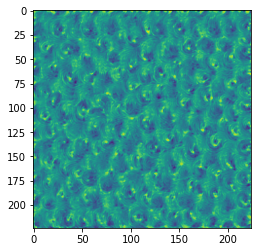

In [74]:


print("dim: ", images[3][0].shape)
fig = plt.figure()
plt.imshow(images[3][0], interpolation= 'bicubic')
fig

In [70]:
 models.vgg16(pretrained=True).features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(

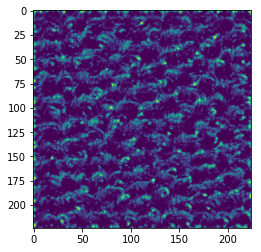

In [67]:

fig = plt.figure()
plt.imshow(layer_vis.created_image[:,:,0], interpolation= 'bicubic')
fig


In [26]:
pretrained_model[17]
images[1].permute(2,1,0).shape

torch.Size([224, 224, 3])